In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from collections import Counter
from scipy import stats

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns

In [3]:
#path_csb22_IL = r"C:\Users\tangz\Desktop\US_CornSoy_ClassificationYield\GeoData\Vectors\csb_IL_2022.shp"
path_csb22_IL = r"D:\US_CornSoy_ClassificationYield\Geodata\csb_IL_2022.shp"
csb22_IL = gpd.read_file(path_csb22_IL)

# Preprocess

In [4]:
csb22_IL.columns

Index(['CSBID', 'CSBYEARS', 'CSBACRES', 'R15', 'R16', 'R17', 'R18', 'R19',
       'R20', 'R21', 'R22', 'STATEFIPS', 'STATEASD', 'ASD', 'CNTY', 'CNTYFIPS',
       'INSIDE_X', 'INSIDE_Y', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area',
       'geometry'],
      dtype='object')

In [8]:
csb22_IL['STATEASD'].unique()

array(['1710', '1720', '1760', '1740', '1770', '1730', '1750', '1780',
       '1790'], dtype=object)

In [5]:
csb22_IL['CNTYFIPS'].unique()

array(['085', '015', '177', '141', '201', '089', '031', '043', '111',
       '037', '007', '097', '117', '061', '083', '137', '171', '149',
       '013', '167', '021', '115', '173', '135', '051', '005', '119',
       '001', '107', '129', '017', '009', '039', '125', '067', '169',
       '057', '113', '109', '179', '143', '203', '095', '187', '071',
       '155', '123', '073', '175', '131', '099', '011', '161', '103',
       '195', '023', '033', '101', '029', '139', '035', '049', '045',
       '025', '041', '147', '019', '183', '079', '053', '105', '075',
       '091', '159', '197', '063', '093', '003', '181', '199', '077',
       '087', '153', '145', '055', '157', '189', '081', '163', '133',
       '121', '027', '127', '165', '151', '059', '069', '193', '191',
       '065', '047', '185'], dtype=object)

In [9]:
#subset columns 
csb22_IL = csb22_IL[['CSBID','CSBACRES','R15', 'R16', 'R17', 'R18', 'R19','R20', 'R21', 'R22', 'CNTY','CNTYFIPS', 'STATEASD']]
#set CNTYFIPS to string
csb22_IL['CNTYFIPS'] = csb22_IL['CNTYFIPS'].astype(str)
csb22_IL['STATEASD'] = csb22_IL['STATEASD'].astype(str)
csb22_IL.head()
# reclassify R15-R22 to three classes 
def tri_classes(value):
    if value == 1:
        return 'Corn'
    elif value == 5:
        return 'Soybean'
    else:
        return 'Other'
csb22_IL[['R15', 'R16', 'R17', 'R18', 'R19','R20', 'R21', 'R22']] = csb22_IL[['R15', 'R16', 'R17', 'R18', 'R19','R20', 'R21', 'R22']].applymap(tri_classes)

In [11]:
print(csb22_IL.shape)
print(Counter(csb22_IL['R22']).most_common(5))
print(Counter(csb22_IL['R21']).most_common(5))
print(Counter(csb22_IL['R20']).most_common(5))
print(Counter(csb22_IL['R19']).most_common(5))
print(Counter(csb22_IL['R18']).most_common(5))
print(Counter(csb22_IL['R17']).most_common(5))
print(Counter(csb22_IL['R16']).most_common(5))
print(Counter(csb22_IL['R15']).most_common(5))

(653148, 13)
[('Soybean', 306682), ('Corn', 277308), ('Other', 69158)]
[('Soybean', 298151), ('Corn', 289765), ('Other', 65232)]
[('Corn', 304472), ('Soybean', 289643), ('Other', 59033)]
[('Soybean', 268495), ('Corn', 255585), ('Other', 129068)]
[('Soybean', 294920), ('Corn', 283479), ('Other', 74749)]
[('Soybean', 292525), ('Corn', 290433), ('Other', 70190)]
[('Corn', 300714), ('Soybean', 271237), ('Other', 81197)]
[('Corn', 297572), ('Soybean', 258952), ('Other', 96624)]


In [12]:
# aggregate the CSBACRES based on R22 column of csb22_IL
agg_corn22_IL_cnty = csb22_IL[csb22_IL['R22'] == 'Corn'].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES': 'sum'})
agg_corn22_IL_cnty = agg_corn22_IL_cnty.reset_index()
print(agg_corn22_IL_cnty.shape)
agg_corn22_IL_cnty.head()

(102, 3)


,CNTYFIPS,CNTY,CSBACRES
0,001,Adams,143505.067917
1,003,Alexander,4687.555692
2,005,Bond,68344.472991
3,007,Boone,71288.880834
4,009,Brown,33213.755483


# Compare with actual acreage 

In [128]:
usda_IL_corn_22_area = pd.read_csv(r"C:\Users\tangz\Desktop\US_CornSoy_ClassificationYield\TabularData\Illinois_Corn_2022_Area.csv")
usda_IL_corn_22_area = usda_IL_corn_22_area[usda_IL_corn_22_area["COMMODITY"] == 'CORN']
print(usda_IL_corn_22_area.columns)
print(usda_IL_corn_22_area.shape)
usda_IL_corn_22_area = usda_IL_corn_22_area[["COUNTY ANSI", "LOCATION", "AREA PLANTED in ACRES"]]
usda_IL_corn_22_area.head()
# usda_IL_corn_22_area.rename(columns={"COUNTY ANSI": "COUNTY_FIPS", "AREA PLANTED in ACRES": "Area_USDA"}, inplace=True)

Index(['YEAR', 'LOCATION', 'STATE ANSI', 'ASD CODE', 'COUNTY ANSI',
       'REFERENCE PERIOD', 'COMMODITY', 'PRODN PRACTICE',
       'AREA HARVESTED in ACRES', 'PRODUCTION in BU', 'YIELD in BU / ACRE',
       'AREA PLANTED in ACRES'],
      dtype='object')
(95, 12)


,COUNTY ANSI,LOCATION,AREA PLANTED in ACRES
0,039,"ILLINOIS, CENTRAL, DE WITT","102,500"
1,107,"ILLINOIS, CENTRAL, LOGAN","178,500"
2,115,"ILLINOIS, CENTRAL, MACON","142,500"
3,123,"ILLINOIS, CENTRAL, MARSHALL","91,600"
4,125,"ILLINOIS, CENTRAL, MASON","114,500"


r-squared: 0.9983604895099553
Total Acres_CSB: 10339579.315914819
Total Acres_USDA: 10259000
Difference Percentage: 0.7854500040434644


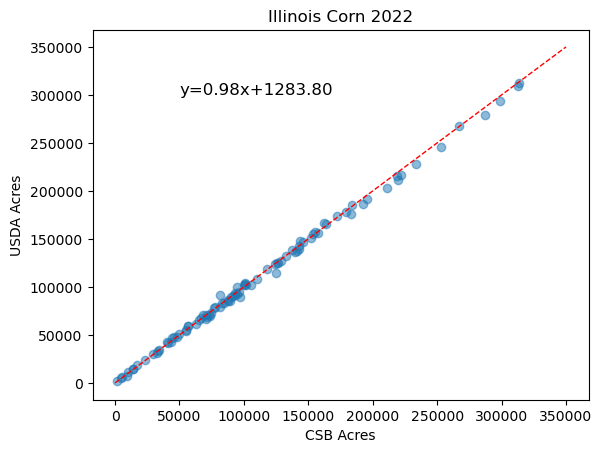

In [129]:
#merge two dataframe agg_corn22_IL_cnty and usda_IL_corn_22_area, based on CNTYFIPS and COUNTY ANSI columns 
df = pd.merge(agg_corn22_IL_cnty, usda_IL_corn_22_area, how='inner', left_on=['CNTYFIPS'], right_on=['COUNTY ANSI'])
df.rename(columns={'AREA PLANTED in ACRES': 'Acres_USDA', 'CSBACRES':'Acres_CSB'}, inplace=True)
# Change Acres_CSB and Acres_USDA columns to numeric
df['Acres_CSB'] = pd.to_numeric(df['Acres_CSB'])
df['Acres_USDA'] = pd.to_numeric(df['Acres_USDA'].str.replace(',', ''))

# scatter plot of Acres_CSB and Acres_USDA
x = df['Acres_CSB']
y = df['Acres_USDA']
plt.scatter(x, y, alpha=0.5)
#plt.title('Acres_CSB vs Acres_USDA')
plt.xlabel('CSB Acres')
plt.ylabel('USDA Acres')
plt.title('Illinois Corn 2022')
#set x and y limits to be the same, and add a diagonal line
#plt.xlim(0, )
#plt.ylim(0, 1000)
plt.plot([0, 350000], [0, 350000], color='red', lw=1, linestyle='--')

#calculate the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
# print the slope and intercept of the equation on the plot
plt.text(50000, 300000, 'y={:.2f}x+{:.2f}'.format(slope,intercept), color='black', fontsize=12)
print('r-squared:', r_value**2)
# Tota Acres
print('Total Acres_CSB:', df['Acres_CSB'].sum())
print('Total Acres_USDA:', df['Acres_USDA'].sum())
print('Difference Percentage:', (df['Acres_CSB'].sum() - df['Acres_USDA'].sum())/df['Acres_USDA'].sum()*100)

plt.show()

# Baseline model

In [13]:
csb22_IL.columns

Index(['CSBID', 'CSBACRES', 'R15', 'R16', 'R17', 'R18', 'R19', 'R20', 'R21',
       'R22', 'CNTY', 'CNTYFIPS', 'STATEASD'],
      dtype='object')

In [54]:
def pre_process(df, n_var, yr):
    """
    df: raw csb dataframe
    n_var: number of variables to be used for the modeling, e.g. 3
    yr: prediction year, e.g. 22 for 2022
    """
    if yr < 23:
        col_y = 'R' + str(yr)
        df_y = df[col_y]
        #subset columns from yr-n_var to yr-1
        col_x = ['R' + str(i) for i in range(yr-n_var, yr)]
        df_x = df[col_x]
        #Rename the columns in col_x: call it yr_1, yr_2, yr_3, etc. 
        df_x.columns = ['yr' + str(i) for i in range(1, n_var+1)]
        #Encode the categorical variables
        df_x = pd.get_dummies(df_x)
        df_y = LabelEncoder().fit_transform(df_y)
        #Add the CSBACRES column to df_x
        df_x['CSBACRES'] = df['CSBACRES']
        #Add the ASD column to df_x
        df_stateasd = pd.get_dummies(df['STATEASD'])
        #rename the columns in df_stateasd
        df_stateasd.columns = ['STATEASD_' + str(i) for i in df_stateasd.columns]
        df_x = pd.concat([df_x, df_stateasd], axis=1)

        #Return the processed data
        return df_x, df_y
    else: 
        col_x = ['R' + str(i) for i in range(yr-n_var, yr)]
        df_x = df[col_x]
        #Rename the columns in col_x: call it yr_1, yr_2, yr_3, etc. 
        df_x.columns = ['yr' + str(i) for i in range(1, n_var+1)]
        #Encode the categorical variables
        df_x = pd.get_dummies(df_x)
        #Add the CSBACRES column to df_x
        df_x['CSBACRES'] = df['CSBACRES']
        #Add the ASD column to df_x
        df_stateasd = pd.get_dummies(df['STATEASD'])
        #rename the columns in df_stateasd
        df_stateasd.columns = ['STATEASD_' + str(i) for i in df_stateasd.columns]
        df_x = pd.concat([df_x, df_stateasd], axis=1)
        #return the processed data
        return df_x

In [22]:
le = LabelEncoder()
encoded = le.fit_transform(csb22_IL['R21'])
mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(mapping)

{'Corn': 0, 'Other': 1, 'Soybean': 2}


In [55]:
X_5_20, Y_20 = pre_process(csb22_IL, n_var = 5, yr = 20)
X_5_21, Y_21 = pre_process(csb22_IL, n_var = 5, yr = 21)
X_5_22, Y_22 = pre_process(csb22_IL, n_var = 5, yr = 22)
X_5_23 = pre_process(csb22_IL, n_var = 5, yr = 23)
# X_train, X_test, y_train, y_test = train_test_split(X_5_21, Y_21, test_size=0.2, random_state=777)

In [60]:
def rf_model_all(csbdf, yr, X, Y, Xnew = None, Ynew = None):
    """
    csbdf: raw csb dataframe
    yr: prediction year, e.g. 22 for 2022
    X: X_train
    Y: Y_train
    Xnew: X_test
    Ynew: Y_test
    """
    # #Generate dataframe 
    # X, Y = pre_process(csbdf, n_var = 5, yr = yr)
    #Train the model
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
    clf_rf.fit(X, Y)
    Ypred_new = clf_rf.predict(Xnew)
    if Ynew is not None:
        Accuracy = accuracy_score(Ynew, Ypred_new)
        CM = confusion_matrix(Ynew, Ypred_new)
        print('Accuracy: ', Accuracy)
        # print('Confusion Matrix: ', CM)
    
    #Calculate total acres of each class
    df_results = csbdf.copy()
    df_results['R{}_PED'.format(yr)] = Ypred_new
    #Predicted total acres
    df_corn1 = df_results[df_results['R{}_PED'.format(yr)] == 0].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES': 'sum'}).reset_index() #Corn
    df_corn1.rename(columns={'CSBACRES': 'CornAcres_Pred'}, inplace=True)
    df_soy1 = df_results[df_results['R{}_PED'.format(yr)] == 2].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES': 'sum'}).reset_index() #Soybean
    df_soy1.rename(columns={'CSBACRES': 'SoyAcres_Pred'}, inplace=True)
    if Ynew is not None:
        #Actual total acres
        df_corn2 = df_results[df_results['R{}'.format(yr)] == 'Corn'].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES': 'sum'}).reset_index() #Corn
        df_corn2.rename(columns={'CSBACRES': 'CornAcres_Actual'}, inplace=True)
        df_soy2 = df_results[df_results['R{}'.format(yr)] == 'Soybean'].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES': 'sum'}).reset_index() #Soybean
        df_soy2.rename(columns={'CSBACRES': 'SoyAcres_Actual'}, inplace=True)
        #Merge the two dataframes
        df_corn = pd.merge(df_corn1, df_corn2, how='inner', left_on=['CNTYFIPS','CNTY'], right_on=['CNTYFIPS','CNTY'])
        df_soy = pd.merge(df_soy1, df_soy2, how='inner', left_on=['CNTYFIPS','CNTY'], right_on=['CNTYFIPS','CNTY'])
        #Sum of the total acres
        Sum_Corn_Pred = df_corn['CornAcres_Pred'].sum()
        Sum_Corn_Actual = df_corn['CornAcres_Actual'].sum()
        Sum_Soy_Pred = df_soy['SoyAcres_Pred'].sum()
        Sum_Soy_Actual = df_soy['SoyAcres_Actual'].sum()
        df_sum = pd.DataFrame({'YR':[yr],'Sum_Corn_Pred': [Sum_Corn_Pred], 'Sum_Corn_Actual': [Sum_Corn_Actual], 'Sum_Soy_Pred': [Sum_Soy_Pred], 'Sum_Soy_Actual': [Sum_Soy_Actual]})
        df_sum['Diff_Corn'] = df_sum['Sum_Corn_Pred'] - df_sum['Sum_Corn_Actual']
        df_sum['Diff_Soy'] = df_sum['Sum_Soy_Pred'] - df_sum['Sum_Soy_Actual']
        df_sum['Diff_Corn_Percent'] = df_sum['Diff_Corn']/df_sum['Sum_Corn_Actual']*100
        df_sum['Diff_Soy_Percent'] = df_sum['Diff_Soy']/df_sum['Sum_Soy_Actual']*100
        print(df_sum)
        
        return clf_rf, Ypred_new, Accuracy, CM, df_corn, df_soy, df_sum
    else:
        return clf_rf, Ypred_new, df_corn1, df_soy1

In [61]:
clf_rf_23, Ypred_23, df_corn23, df_soy23 = rf_model_all(csb22_IL, 23, X_5_22, Y_22, X_5_23)

In [64]:
print(df_corn23['CornAcres_Pred'].sum())
print(df_soy23['SoyAcres_Pred'].sum())

10871767.421487965
11212266.168125633


In [47]:
# clf_rf_23, Ypred_23, Acc_23, CM_23, df_corn23, df_soy23 = rf_model_all(csb22_IL, 23, X_5_22, Y_22)

clf_rf_22, Ypred_22, Acc_22, CM_22, df_corn22, df_soy22, df_sum22 = rf_model_all(csb22_IL, 22, X_5_21, Y_21, X_5_22, Y_22)
clf_rf_21, Ypred_21, Acc_21, CM_21, df_corn21, df_soy21, df_sum21 = rf_model_all(csb22_IL, 21, X_5_20, Y_20, X_5_21, Y_21)

Accuracy:  0.7588969115728748
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   1.154554e+07     1.087936e+07  1.061980e+07    1.059549e+07   

       Diff_Corn      Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0  666186.684035  24312.249777           6.123402          0.229458  
Accuracy:  0.7133681799530888
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  21   1.174348e+07     1.111852e+07  1.043603e+07    1.035271e+07   

       Diff_Corn      Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0  624952.269733  83315.556006           5.620821           0.80477  


In [57]:
1.087936e+07 - 10879360

0.0

In [48]:
df_sum22

,YR,Sum_Corn_Pred,Sum_Corn_Actual,Sum_Soy_Pred,Sum_Soy_Actual,Diff_Corn,Diff_Soy,Diff_Corn_Percent,Diff_Soy_Percent
0,22,1.154554e+07,1.087936e+07,1.061980e+07,1.059549e+07,666186.684035,24312.249777,6.123402,0.229458


In [49]:
df_sum21

,YR,Sum_Corn_Pred,Sum_Corn_Actual,Sum_Soy_Pred,Sum_Soy_Actual,Diff_Corn,Diff_Soy,Diff_Corn_Percent,Diff_Soy_Percent
0,21,1.174348e+07,1.111852e+07,1.043603e+07,1.035271e+07,624952.269733,83315.556006,5.620821,0.80477


In [50]:
df_sum22['Sum_Soy_Actual'] - df_sum21['Sum_Soy_Actual']

0    242778.676604
Name: Sum_Soy_Actual, dtype: float64

In [43]:
df_sum22['Diff_Corn'] = df_sum22['Sum_Corn_Pred'] - df_sum22['Sum_Corn_Actual']
df_sum22['Diff_Soy'] = df_sum22['Sum_Soy_Pred'] - df_sum22['Sum_Soy_Actual']
df_sum22['Diff_Corn_Percent'] = df_sum22['Diff_Corn']/df_sum22['Sum_Corn_Actual']*100
df_sum22['Diff_Soy_Percent'] = df_sum22['Diff_Soy']/df_sum22['Sum_Soy_Actual']*100
df_sum22

,YR,Sum_Corn_Pred,Sum_Corn_Actual,Sum_Soy_Pred,Sum_Soy_Actual,Diff_Corn,Diff_Soy,Diff_Corn_Percent,Diff_Soy_Percent
0,22,1.133602e+07,1.087936e+07,9.945422e+06,1.059549e+07,456668.754902,-650066.970249,4.197572,-6.135318


In [188]:
clf_rf5 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
clf_rf5.fit(X_5_21, Y_21)

RandomForestClassifier(max_depth=5, random_state=0)

In [192]:
y_pred_rf5_22 = clf_rf5.predict(X_5_22)

In [193]:
print("Accuracy:",accuracy_score(Y_22, y_pred_rf5_22))
cm = confusion_matrix(Y_22, y_pred_rf5_22)
print(cm)

Accuracy: 0.7567810052239309
[[234077   2181  41050]
 [ 34248  21677  13233]
 [ 66624   1522 238536]]


In [196]:
# Calculate how many equals to 0
df_results = csb22_IL.copy()
df_results['R22_PED'] = y_pred_rf5_22

r2 = 0.9475347549711155
y = 1.029441716982933x + -8664.275345659931
Predicted Yield: 11426690
Actual Yield: 10879355
Difference Percentage: 0.05030947805940035


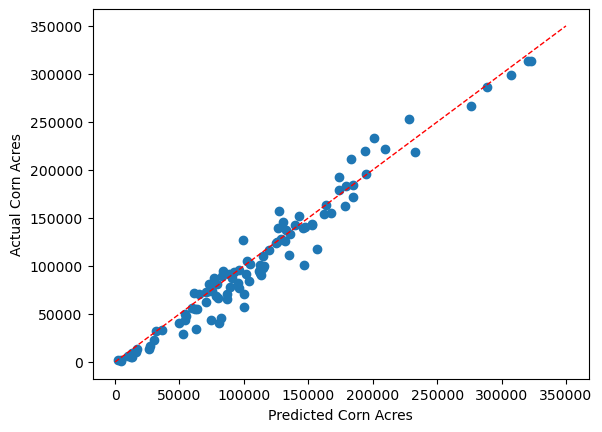

In [213]:
df1 = df_results[df_results['R22_PED'] == 0].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES': 'sum'})
df1 = df1.reset_index()
df2 = df_results[df_results['R22'] == 'Corn'].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES': 'sum'})
df2 = df2.reset_index()
df2
x = df1['CSBACRES'] # Predicted Acres
y = df2['CSBACRES'] # Actual Acres
plt.scatter(x, y)
# Add 1:1 line
plt.plot([0, 350000], [0, 350000], color='red', linestyle='--', linewidth=1)
# Add labels
plt.xlabel('Predicted Corn Acres')
plt.ylabel('Actual Corn Acres')
# Calculate r2 and linear equation
r2 = r2_score(x, y)
print(f'r2 = {r2}')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f'y = {slope}x + {intercept}')


#TOTAL ACRES (Keep only the integer part of the number)
x_sum = x.sum()
y_sum = y.sum()
print("Predicted Yield: " + str(x_sum.astype(int)))
print("Actual Yield: "+ str(y_sum.astype(int)))
print("Difference Percentage: " + str((x.sum() - y.sum())/y.sum()))

plt.show()

In [178]:
clf_rf5 = RandomForestClassifier(n_estimators=100, max_depth=2,random_state = 77)
clf_rf5.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=77)

In [ ]:
clf_gb5 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=77)
clf_gb5.fit(X_train, y_train)

In [186]:
accuracy_score(y_test, y_pred_rf5)

0.6856158615938146

In [180]:
y_pred_rf5 = clf_rf5.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred_rf5))
cm = confusion_matrix(y_test, y_pred_rf5)
print(cm)

Accuracy: 0.6856158615938146
[[42788     0 14963]
 [ 9401     0  3671]
 [13033     0 46774]]


In [131]:
#train a machine learning model based on training data
training, testing = train_test_split(XY_3, test_size=0.8, random_state=42)
X_train = training.drop(['R21'], axis=1)
y_train = training['R21']
X_test = testing.drop(['R21'], axis=1)
y_test = testing['R21']

In [ ]:
clf_rf3 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf_rf3.fit(X_train, y_train)

In [ ]:
report = classification_report(y_test, y_pred_rf3, target_names=['1','2','3'])

In [174]:
print(report)

              precision    recall  f1-score   support

           1       0.64      0.74      0.69     57751
           2       0.00      0.00      0.00     13072
           3       0.72      0.77      0.74     59807

    accuracy                           0.68    130630
   macro avg       0.45      0.50      0.48    130630
weighted avg       0.61      0.68      0.65    130630



In [164]:
cm_df = pd.DataFrame(cm, index = clf_rf3.classes_, columns = clf_rf3.classes_)
cm_df

,0,1,2
0,42638,0,15113
1,10034,0,3038
2,13544,0,46263


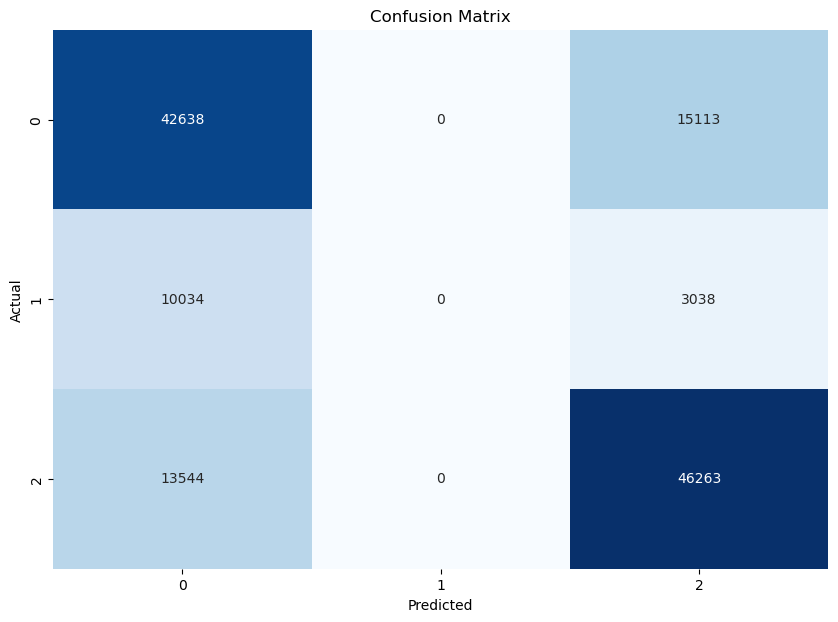

In [167]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
